# Generate mask data files


In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.utils import data as data_utils
from astropy.nddata import bitmask

# version dependencies are currently an issue
import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

# import json
# import requests
from dl import authClient as ac, queryClient as qc
import pandas as pd
import os

In [2]:
os.path.basename('NGC-star-clusters.fits')
dir_name=os.path.dirname('NGC-star-clusters.fits')
path=os.path.abspath('NGC-star-clusters.fits')
print(dir_name)
print(path)


/Users/vernica/Documents/GitHub/WiFeS_Catalog/NGC-star-clusters.fits


In [3]:
# Escape backslashes by doubling them, explicitly indicating that they should be treated as literal characters.
mask_string ="/Users/vernica/Documents/GitHub/WiFeS_Catalog/NGC-star-clusters.fits"
# mask_string = "https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/masking/gaia-mask-dr10.fits.gz"
print("Loading file...")
hdu = fits.open(mask_string, memmap=True)
hdu.info()

Loading file...
Filename: /Users/vernica/Documents/GitHub/WiFeS_Catalog/NGC-star-clusters.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     24   346R x 8C   [14A, 4A, 6A, D, D, D, D, D]   


In [4]:
print("File loaded. Assigning header and data...")
mask_header = hdu[1].header
mask_data = hdu[1].data


File loaded. Assigning header and data...


In [ ]:

print(mask_header)
print(mask_data['G_MAG_SB22'])
print(mask_data['BA'])
print(repr(mask_header))
# print header info

In [95]:
#Doing a check of the data array sizes at ech step
mask_data_c=mask_data[(mask_data['G_MAG_SB22']<=21)&(mask_data['G_MAG_SB22']>=0)]
print(mask_data_c.shape)
mask_data_c = mask_data_c[mask_data_c['DEC'] < 30]
print(mask_data_c.shape)

(353531,)
(255282,)


In [ ]:
#check if any values that are not -1 are in the coloumn for G_MAG_SB22
#mask_data_cut = mask_data[(mask_data['G_MAG_SB22']<=21)]
with np.printoptions(threshold=2000, suppress=False, linewidth=75):
    array=mask_data['G_MAG_SB22']
    non_neg_one=[]
    for i in range(0,len(array)):
        if array[i]>-1:
            non_neg_one.append(array[i])
    print(min(non_neg_one))
    print(max(non_neg_one))


8.865208
50.59867


In [88]:
#Only extract rows with values in the magnitude column that meet the requirements 
mask_data_cut = mask_data[(mask_data['G_MAG_SB22']<=21) & (mask_data['G_MAG_SB22']>=0)|(mask_data['R_MAG_SB22']<=21) & (mask_data['R_MAG_SB22']>=0)|(mask_data['Z_MAG_SB22']<=21) & (mask_data['Z_MAG_SB22']>=0)]
#mask_data_cut = mask_data[(mask_data['G_MAG_SB22']<=21) & (mask_data['G_MAG_SB22']>=0)]
print('G_Min is', min(mask_data_cut['G_MAG_SB22']))
print('G_Max is',max(mask_data_cut['G_MAG_SB22']))
print('R_Min is', min(mask_data_cut['R_MAG_SB22']))
print('R_Max is',max(mask_data_cut['R_MAG_SB22']))
print('Z_Min is', min(mask_data_cut['Z_MAG_SB22']))
print('Z_Max is',max(mask_data_cut['Z_MAG_SB22']))
print(mask_data_cut['G_MAG_SB22'][0:10])
print(mask_data_cut['R_MAG_SB22'][0:10])
print(mask_data_cut['Z_MAG_SB22'][0:10])

G_Min is -1.0
G_Max is 50.59867
R_Min is -1.0
R_Max is 22.71768
Z_Min is -1.0
Z_Max is 43.337307
[17.526522 16.69055  19.417446 16.842518 17.15974  17.04892  17.018696
 20.867655 18.596725 17.26564 ]
[16.690638 15.660881 18.075287 15.811423 16.361364 16.120785 16.205322
 20.074892 17.522785 16.236042]
[16.026987  14.856083  16.899792  15.038198  15.6983385 15.418322
 15.514487  19.51936   16.683441  15.443166 ]


In [7]:
print("Dropping unneeded columns...(Retaining ra, dec, diam, ba, pa, g_mag_sb22, r_mag_sb22, z-mag_sb22)")
drop_fields = mask_data.names
allowed_fields = ['RA', 'DEC', 'RADIUS']
drop_fields = [field for field in drop_fields if field not in allowed_fields]
mask_data_cut = np.lib.recfunctions.rec_drop_fields(mask_data, drop_fields)


Dropping unneeded columns...(Retaining ra, dec, diam, ba, pa, g_mag_sb22, r_mag_sb22, z-mag_sb22)


In [ ]:
# Cut out all stars at declinations above DEC
dec=30
print(f"Removing galaxies above DEC = {dec}")
mask_data_cut = mask_data_cut[mask_data_cut['DEC'] < dec]
print(mask_data_cut.shape)

# close everything
print("Data cleaned!")
hdu.close()
del hdu

print(max(mask_data_cut['R_MAG_SB22']))


Removing galaxies above DEC = 30
(259311,)
Data cleaned!
22.2285


In [4]:
np.savez_compressed(f'mask_data_clusters', mask_data_cut)

In [3]:
# WARNING this takes a long time (~4 min)

def generate_masked_stars(dec=30):
    """Generates a numpy file object of the masked stars
    
    DO NOT run this function unless absolutely necessary!!!!
    It takes ~4 minutes on its own excluding the amount of time needed to download
    the mask fits file.
    
    Parameters
    ----------
    dec: `float`
        Maximum declination to cut off the catalog at (default = 30)
    """
    
    mask_string = "/Users/vernica/Documents/GitHub/WiFeS_Catalog/NGC-star-clusters.fits"
    # mask_string = "https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/masking/gaia-mask-dr10.fits.gz"
    print("Loading file...")
    hdu = fits.open(mask_string, memmap=True)
    
    # hdu.info()
    print("File loaded. Assigning header and data...")
    mask_header = hdu[1].header
    mask_data = hdu[1].data

    # check if sources in desi and isbright / is medium
    print("Checking for bright/medium stars in DESI footprint...")
    #mask_data_cut = mask_data[(mask_data['isbright'] | mask_data['ismedium'])]

    # drop unneeded columns first
    print("Dropping unneeded columns...(Retaining ra, dec, radius)")
    drop_fields = mask_data.names
    allowed_fields = ['ra', 'dec', 'radius']
    drop_fields = [field for field in drop_fields if field not in allowed_fields]
    mask_data_cut = np.lib.recfunctions.rec_drop_fields(mask_data, drop_fields)
    
    # Cut out all stars at declinations above DEC
    print(f"Removing stars above DEC = {dec}")
    mask_data_cut = mask_data_cut[mask_data_cut['dec'] < dec]

    # close everything
    print("Data cleaned!")
    hdu.close()
    del hdu
    
    return mask_data_cut

mask_data_cut = generate_masked_stars()

Loading file...
File loaded. Assigning header and data...
Checking for bright/medium stars in DESI footprint...
Dropping unneeded columns...(Retaining ra, dec, radius)
Removing stars above DEC = 30
Data cleaned!


In [15]:
# only consider stuff below a declination of 30

def generate_boxes(ra_interval, dec_interval):
    
    
    ra_ranges = np.arange(0, 360, ra_interval)
    dec_ranges = np.arange(-90, 30, dec_interval)

    print(ra_ranges)
    print(dec_ranges)
    
    mask_box = []
    
    for ra in ra_ranges:
        ra_bounds = (mask_data_cut['ra'] > ra) & (mask_data_cut['ra'] < ra+ra_interval)
        
        for dec in dec_ranges:
            dec_bounds = (mask_data_cut['dec'] > dec) & (mask_data_cut['dec'] < dec+dec_interval)
            
            print(f"RA: {ra}, DEC: {dec}")
            mask_box.append(mask_data_cut[ra_bounds & dec_bounds])
        
    return mask_box

mask_box = generate_boxes(70, 24)

[  0  70 140 210 280 350]
[-90 -66 -42 -18   6]
RA: 0, DEC: -90
RA: 0, DEC: -66
RA: 0, DEC: -42
RA: 0, DEC: -18
RA: 0, DEC: 6
RA: 70, DEC: -90
RA: 70, DEC: -66
RA: 70, DEC: -42
RA: 70, DEC: -18
RA: 70, DEC: 6
RA: 140, DEC: -90
RA: 140, DEC: -66
RA: 140, DEC: -42
RA: 140, DEC: -18
RA: 140, DEC: 6
RA: 210, DEC: -90
RA: 210, DEC: -66
RA: 210, DEC: -42
RA: 210, DEC: -18
RA: 210, DEC: 6
RA: 280, DEC: -90
RA: 280, DEC: -66
RA: 280, DEC: -42
RA: 280, DEC: -18
RA: 280, DEC: 6
RA: 350, DEC: -90
RA: 350, DEC: -66
RA: 350, DEC: -42
RA: 350, DEC: -18
RA: 350, DEC: 6


In [18]:
for i, box in enumerate(mask_box):
    print(f"Saving mask_data_{i}")
    np.savez_compressed(f'mask_data_{i}', box)
    
print("Done")

Saving mask_data_0
Saving mask_data_1
Saving mask_data_2
Saving mask_data_3
Saving mask_data_4
Saving mask_data_5
Saving mask_data_6
Saving mask_data_7
Saving mask_data_8
Saving mask_data_9
Saving mask_data_10
Saving mask_data_11
Saving mask_data_12
Saving mask_data_13
Saving mask_data_14
Saving mask_data_15
Saving mask_data_16
Saving mask_data_17
Saving mask_data_18
Saving mask_data_19
Saving mask_data_20
Saving mask_data_21
Saving mask_data_22
Saving mask_data_23
Saving mask_data_24
Saving mask_data_25
Saving mask_data_26
Saving mask_data_27
Saving mask_data_28
Saving mask_data_29
Done


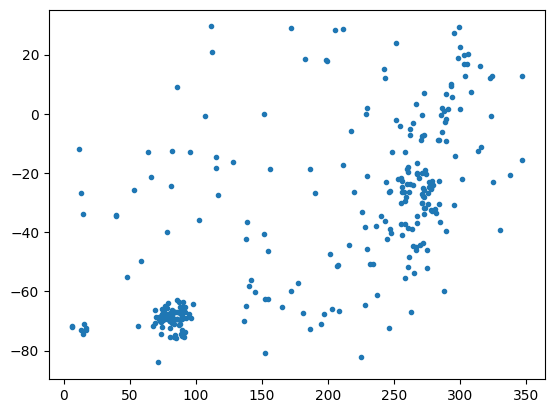

In [8]:
fig, ax = plt.subplots()
# ax.plot(mask_data_cut['ra'], mask_data_cut['dec'])
ax.plot(mask_data_cut['ra'],mask_data_cut['dec'],'.')
# for box in mask_box:
#     ax.plot(box['RA'], box['DEC'], '.')
# ax.vlines(ra_ranges, ymin=-90, ymax=30, color='r')
# ax.hlines(dec_ranges, xmin=0, xmax=360, color='r')
plt.show()

In [ ]:
cluster_masks = []

with np.load(f"mask_data_files/mask_data_clusters.npz", mmap_mode='r') as mask_data:
    mask_array = mask_data['arr_0']
    mask_array_byteswap = mask_array.byteswap().newbyteorder()
    masked_stars = pd.DataFrame(mask_array_byteswap)
    cluster_masks.append(masked_stars)

In [ ]:
df = pd.DataFrame(cluster_masks[0])
df = df.drop([5,77]).reset_index(drop=True)

7.0

## Producing the Mask Data File for Large Galaxies

In [11]:
#Getting the Local path of the downloaded FITS file 
path=os.path.abspath('SGA-ellipse-v3.0.kd.fits')
print(path)

c:\Users\afalv\OneDrive\Documents\WiFeS_Catalog\SGA-ellipse-v3.0.kd.fits


In [12]:
#Open and load information for the FITS file
# Escape backslashes by doubling them, explicitly indicating that they should be treated as literal characters.
mask_string ="C:\\Users\\afalv\\Downloads\\SGA-ellipse-v3.0.kd.fits"
print("Loading file...")
hdu = fits.open(mask_string, memmap=True)
hdu.info()

Loading file...
Filename: C:\Users\afalv\Downloads\SGA-ellipse-v3.0.kd.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1                1 BinTableHDU    583   3131971R x 286C   [1K, 29A, 1K, 1D, 1D, 21A, 1E, 1E, 1E, 1E, 1E, 1E, 1L, 13A, 1L, 1L, 1K, 35A, 1I, 1L, 1D, 1D, 1E, 8A, 1E, 4A, 1E, 1E, 1J, 1J, 1I, 1J, 1J, 1L, 1I, 1L, 6A, 1D, 1D, 1E, 1E, 1E, 1E, 5E, 1E, 1D, 1D, 2A, 1K, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1L, 1E, 1E, 1I, 1E, 1E, 1I, 1E, 1E, 1I, 1L, 1E, 1E, 1I, 1I, 1E, 1L, 1E, 1E, 1E, 1E, 1B, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 8E, 8E, 8E, 8E, 8E, 8E, 8E, 8E, 8E, 8E, 8E, 8E, 8E, 8E, 8E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1I, 1I, 1I, 1I, 1I, 1I, 1I, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1I, 1I, 1I, 1I, 1I, 1I, 1B, 1B, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 8A, 1E, 1E, 1E, 1E, 1E, 1E

In [13]:
#print header info
print("File loaded. Assigning header and data...")
mask_header = hdu[1].header
mask_data = hdu[1].data
print(repr(mask_header))

File loaded. Assigning header and data...
XTENSION= 'BINTABLE' / FITS Binary Table Extension                              
BITPIX  =                    8 / 8-bits character format                        
NAXIS   =                    2 / Tables are 2-D char. array                     
NAXIS1  =                 1834 / Bytes in row                                   
NAXIS2  =              3131971 / no comment                                     
PCOUNT  =                    0 / Parameter count always 0                       
GCOUNT  =                    1 / Group count always 1                           
TFIELDS =                  286 / No. of col in table                            
TFORM1  = '1K      ' / Format of field                                          
TTYPE1  = 'SGA_ID  ' / Field label                                              
TFORM2  = '29A     ' / Format of field                                          
TTYPE2  = 'GALAXY  ' / Field label                                 

In [14]:
#check if there are any values that are not -1 (-1 means not measured) in the column for G_MAG_SB22:
array=mask_data['G_MAG_SB22']
non_neg_one=[]
for i in range(0,len(array)):
    if array[i]>-1:
        non_neg_one.append(array[i])
print(min(non_neg_one))
print(max(non_neg_one))

8.865208
50.59867


In [15]:
#Only extract rows with values in the magnitude column that meet the requirements 
mask_data_cut = mask_data[(mask_data['G_MAG_SB22']<=21) & (mask_data['G_MAG_SB22']>=0)|(mask_data['R_MAG_SB22']<=21) & (mask_data['R_MAG_SB22']>=0)|(mask_data['Z_MAG_SB22']<=21) & (mask_data['Z_MAG_SB22']>=0)]


In [16]:
print("Dropping unneeded columns...(Retaining ra, dec, diam)")
drop_fields = mask_data.names
allowed_fields = ['RA', 'DEC', 'DIAM']
drop_fields = [field for field in drop_fields if field not in allowed_fields]
mask_data_cut = np.lib.recfunctions.rec_drop_fields(mask_data_cut, drop_fields)

Dropping unneeded columns...(Retaining ra, dec, diam)


In [17]:
# Cut out all stars at declinations above dec=30
dec=30
print(f"Removing galaxies above DEC = {dec}")
mask_data_cut = mask_data_cut[mask_data_cut['DEC'] < dec]
print(mask_data_cut['DIAM'])
#Halve the diameter values (in arcmin) to get the radius of the semi-major axis
mask_data_cut['DIAM']=mask_data_cut['DIAM']/2
#Change the name 'DIAM' to 'RADIUS' instead which will help with the implemmenation of the file into the load mask data function
print(mask_data_cut.dtype.names)
mask_data_cut.dtype.names='RADIUS', 'RA', 'DEC'
#Check changes have worked
print(mask_data_cut['RADIUS'])
print(mask_data_cut.shape)
# close everything
print("Data cleaned!")
hdu.close()
del hdu
#Generate mask data file
np.savez_compressed(f'mask_data_galaxies', mask_data_cut)

Removing galaxies above DEC = 30
[0.80713135 0.8575035  0.72197276 ... 0.5795013  0.38990742 0.5803216 ]
('DIAM', 'RA', 'DEC')
[0.40356568 0.42875174 0.36098638 ... 0.28975064 0.19495371 0.2901608 ]
(259311,)
Data cleaned!
